<span style="color:darkgreen"><span style="font-size: 32px;">**Лабораторная работа №4:Неконтролируемая классификация (кластеризация).**</span></span>

<span style="color:darkgreen">Цель: </span>Провести кластеризацию набора содержащего геоданные.</span>

<span style="color:darkgreen">Задачи:</span></span>  Для решения задачи кластеризации выбрать набор содержащий геоданные (координаты, помимо других признаков) (например на сайте kaggle.com / huggingface.co/datasets). Провести кластеризацию этих данных (тремя моделями), настроить гиперпараметры, оценить качество кластеризации (3 метрики), визуализировать результат с использованием карты.

<span style="color:darkgreen"><span style="font-size: 20px;">1 Импорт библиотек: </span></span>

1. **pandas**: Обрабатывает данные в табличной форме (загрузка, фильтрация, выбор признаков).
2. **StandardScaler** (из **sklearn.preprocessing**): Масштабирует данные для улучшения качества кластеризации.
3. **KMeans, DBSCAN, AgglomerativeClustering** (из **sklearn.cluster**): Реализуют различные алгоритмы кластеризации.
4. **silhouette_score, calinski_harabasz_score, davies_bouldin_score** (из **sklearn.metrics**): Оценка качества кластеризации.
5. **folium**: Визуализирует кластеры на интерактивной карте.
6. **seaborn**: Создает графики для визуализации метрик качества.
7. **matplotlib**: Строит графики для отображения результатов кластеризации и метрик.


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import folium
import seaborn as sns
import matplotlib.pyplot as plt

<span style="color:darkgreen"><span style="font-size: 20px;">2. Загрузка и предварительная обработка данных </span></span>

- Загружаем данные о городах с сайта worldcities.csv.

- Если данных больше 10 000 строк, выбираем случайную подвыборку из 30% для уменьшения нагрузки.

- Из данных выбираем ключевые признаки: широту (lat), долготу (lng) и численность населения (population), удаляя строки с пропусками.

In [2]:
# Загрузка данных
data = pd.read_csv('worldcities.csv')

# Уменьшение данных, если размер выборки слишком велик
data_sample = data.sample(frac=0.3, random_state=42) if len(data) > 10000 else data

# Выбор и обработка признаков для кластеризации
features = data_sample[['lat', 'lng', 'population']].dropna()
data_sample = data_sample.loc[features.index]
X = features[['lat', 'lng', 'population']]

<span style="color:darkgreen"><span style="font-size: 20px;">3. Масштабирование данных </span></span>

Данные масштабируются с помощью StandardScaler, чтобы признаки имели одинаковый вклад в алгоритмы кластеризации (среднее 0, стандартное отклонение 1).

In [3]:
# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<span style="color:darkgreen"><span style="font-size: 20px;">4. Определение гиперпараметров и подготовка моделей</span></span>

1. Создаем пустые словари для хранения меток кластеров и метрик качества.

2. Определяем параметры для трех методов кластеризации:

    - KMeans: Количество кластеров = 7, метод инициализации = elkan.
    - DBSCAN: Радиус eps = 0.3, минимальное количество точек = 10.
    - Agglomerative Clustering: Иерархическая кластеризация с 7 кластерами.

In [4]:
# Словарь для хранения результатов кластеризации и оценок
cluster_results = {}
quality_metrics = {}

# Гиперпараметры для кластеризации
kmeans_params = {'n_clusters': 7, 'random_state': 0, 'n_init': 'auto', 'algorithm': 'elkan'}
dbscan_params = {'eps': 0.3, 'min_samples': 10}
agglo_params = {'n_clusters': 7, 'linkage': 'ward'}

<span style="color:darkgreen"><span style="font-size: 20px;">5. Проведение кластеризации</span></span>

Запускаем три алгоритма кластеризации:

- *KMeans* — разделяет данные на 7 кластеров с минимизацией суммы квадратов расстояний до центроидов.
- *DBSCAN* — определяет кластеры по плотности точек в пространстве (обнаруживает шум).
- *Agglomerative Clustering* — объединяет точки в кластеры на основе расстояния (иерархический метод).


In [5]:
# 1. Кластеризация с помощью KMeans
kmeans = KMeans(**kmeans_params)
kmeans_labels = kmeans.fit_predict(X_scaled)
cluster_results['KMeans'] = kmeans_labels

# 2. Кластеризация с помощью DBSCAN
dbscan = DBSCAN(**dbscan_params, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(X_scaled)
cluster_results['DBSCAN'] = dbscan_labels

# 3. Кластеризация с помощью Agglomerative Clustering
agglo = AgglomerativeClustering(**agglo_params)
agglo_labels = agglo.fit_predict(X_scaled)
cluster_results['Agglomerative'] = agglo_labels


<span style="color:darkgreen"><span style="font-size: 20px;">6. Оценка качества кластеризации</span></span>

Для каждой модели вычисляем три метрики качества:

- *Silhouette Score*: Насколько точки принадлежат своим кластерам.
- *Calinski-Harabasz Score*: Соотношение между компактностью кластеров и их разделением.
- *Davies-Bouldin Score*: Средняя близость кластеров, минимальная оценка лучше.

In [6]:
# Оценка качества кластеризации
for model_name, labels in cluster_results.items():
    if len(set(labels)) > 1:  # Проверка на большее, чем один кластер
        silhouette = silhouette_score(X_scaled, labels)
        calinski_harabasz = calinski_harabasz_score(X_scaled, labels)
        davies_bouldin = davies_bouldin_score(X_scaled, labels)
    else:
        silhouette = calinski_harabasz = davies_bouldin = None
    
    # Сохранение оценок в словарь
    quality_metrics[model_name] = {
        "Silhouette Score": silhouette,
        "Calinski-Harabasz Score": calinski_harabasz,
        "Davies-Bouldin Score": davies_bouldin
    }
    print(f"{model_name} - Silhouette Score: {f'{silhouette:.3f}' if silhouette is not None else 'N/A'}, "
          f"Calinski-Harabasz Score: {f'{calinski_harabasz:.3f}' if calinski_harabasz is not None else 'N/A'}, "
          f"Davies-Bouldin Score: {f'{davies_bouldin:.3f}' if davies_bouldin is not None else 'N/A'}")

KMeans - Silhouette Score: 0.512, Calinski-Harabasz Score: 11225.339, Davies-Bouldin Score: 0.770
DBSCAN - Silhouette Score: 0.240, Calinski-Harabasz Score: 1496.882, Davies-Bouldin Score: 1.015
Agglomerative - Silhouette Score: 0.509, Calinski-Harabasz Score: 10248.592, Davies-Bouldin Score: 0.602


<span style="color:darkgreen"><span style="font-size: 20px;">7. Визуализация метрик качества</span></span>

Строим столбчатые диаграммы для визуализации значений метрик.

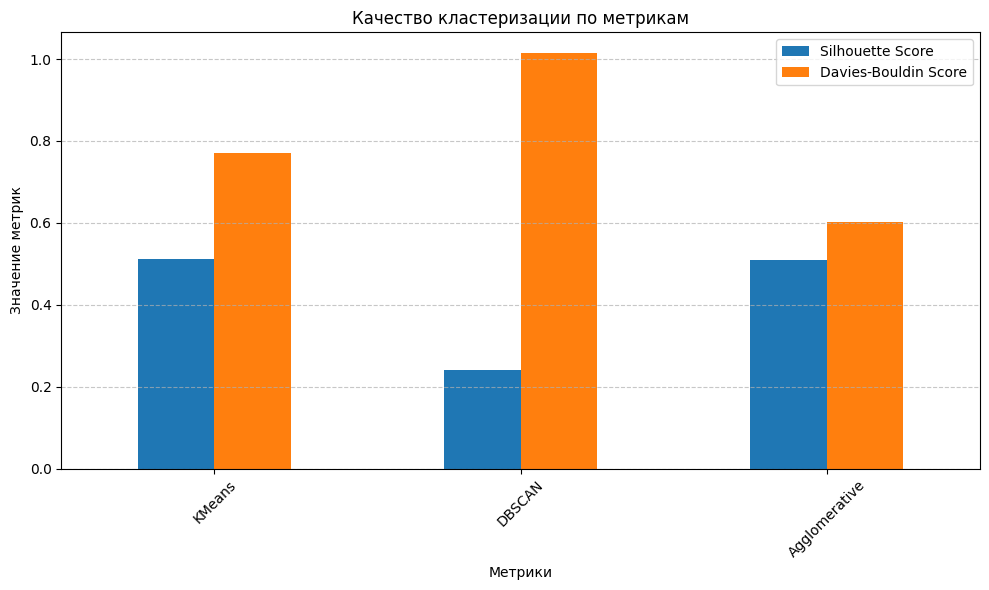

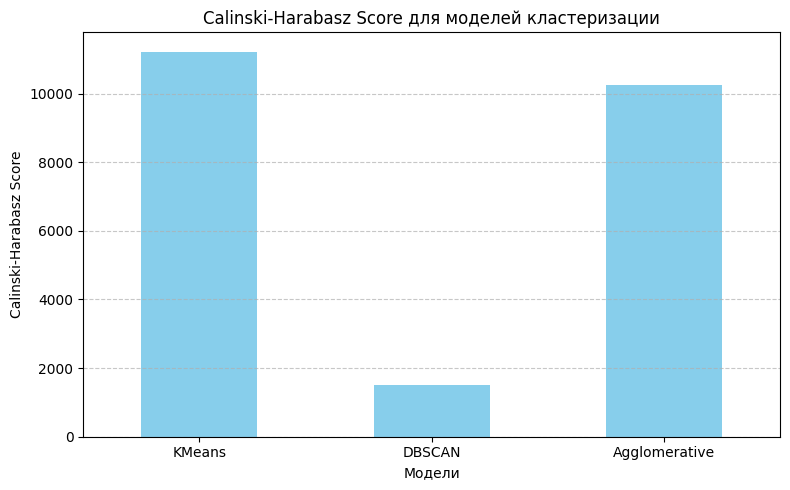

In [7]:
# Визуализация метрик кластеризации (без Calinski-Harabasz Score)
metrics_df = pd.DataFrame(quality_metrics).T.drop(columns=["Calinski-Harabasz Score"])
metrics_df.plot(kind="bar", figsize=(10, 6), title="Качество кластеризации по метрикам")
plt.ylabel("Значение метрик")
plt.xlabel("Метрики")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Создание отдельного графика для Calinski-Harabasz Score
calinski_harabasz_df = pd.DataFrame({
    model_name: metrics["Calinski-Harabasz Score"] 
    for model_name, metrics in quality_metrics.items()
}, index=["Calinski-Harabasz Score"]).T

calinski_harabasz_df.plot(
    kind="bar", 
    figsize=(8, 5), 
    title="Calinski-Harabasz Score для моделей кластеризации", 
    legend=False, 
    color="skyblue"
)
plt.ylabel("Calinski-Harabasz Score")
plt.xlabel("Модели")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

<span style="color:darkgreen"><span style="font-size: 20px;">8. Создание интерактивных карт</span></span>

Генерируем интерактивные карты кластеров для каждой модели и сохраняем их в файлы формата .html.



In [8]:
# Функция для создания карты кластеров
def create_map(labels, model_name):
    data_sample['cluster'] = labels
    m = folium.Map(location=[20, 0], zoom_start=2)
    unique_labels = set(labels)
    colors = sns.color_palette("hsv", len(unique_labels)).as_hex()

    # Ограничение числа городов для отображения
    for _, row in data_sample.sample(n=min(len(data_sample), 500)).iterrows():
        cluster = row['cluster']
        if cluster == -1:  # Для DBSCAN, метка -1 обозначает шум
            color = "#000000"  # Черный для шума
        else:
            color = colors[cluster % len(colors)]
        folium.CircleMarker(
            location=[row['lat'], row['lng']],
            radius=3,
            color=color,
            fill=True,
            fill_opacity=0.7
        ).add_to(m)
    m.save(f"{model_name}_clusters_map.html")
    print(f"Map for {model_name} clustering saved as '{model_name}_clusters_map.html'")

# Создаем карты для каждой модели
for model_name, labels in cluster_results.items():
    create_map(labels, model_name)

Map for KMeans clustering saved as 'KMeans_clusters_map.html'
Map for DBSCAN clustering saved as 'DBSCAN_clusters_map.html'
Map for Agglomerative clustering saved as 'Agglomerative_clusters_map.html'


**Карта для KMeans** 
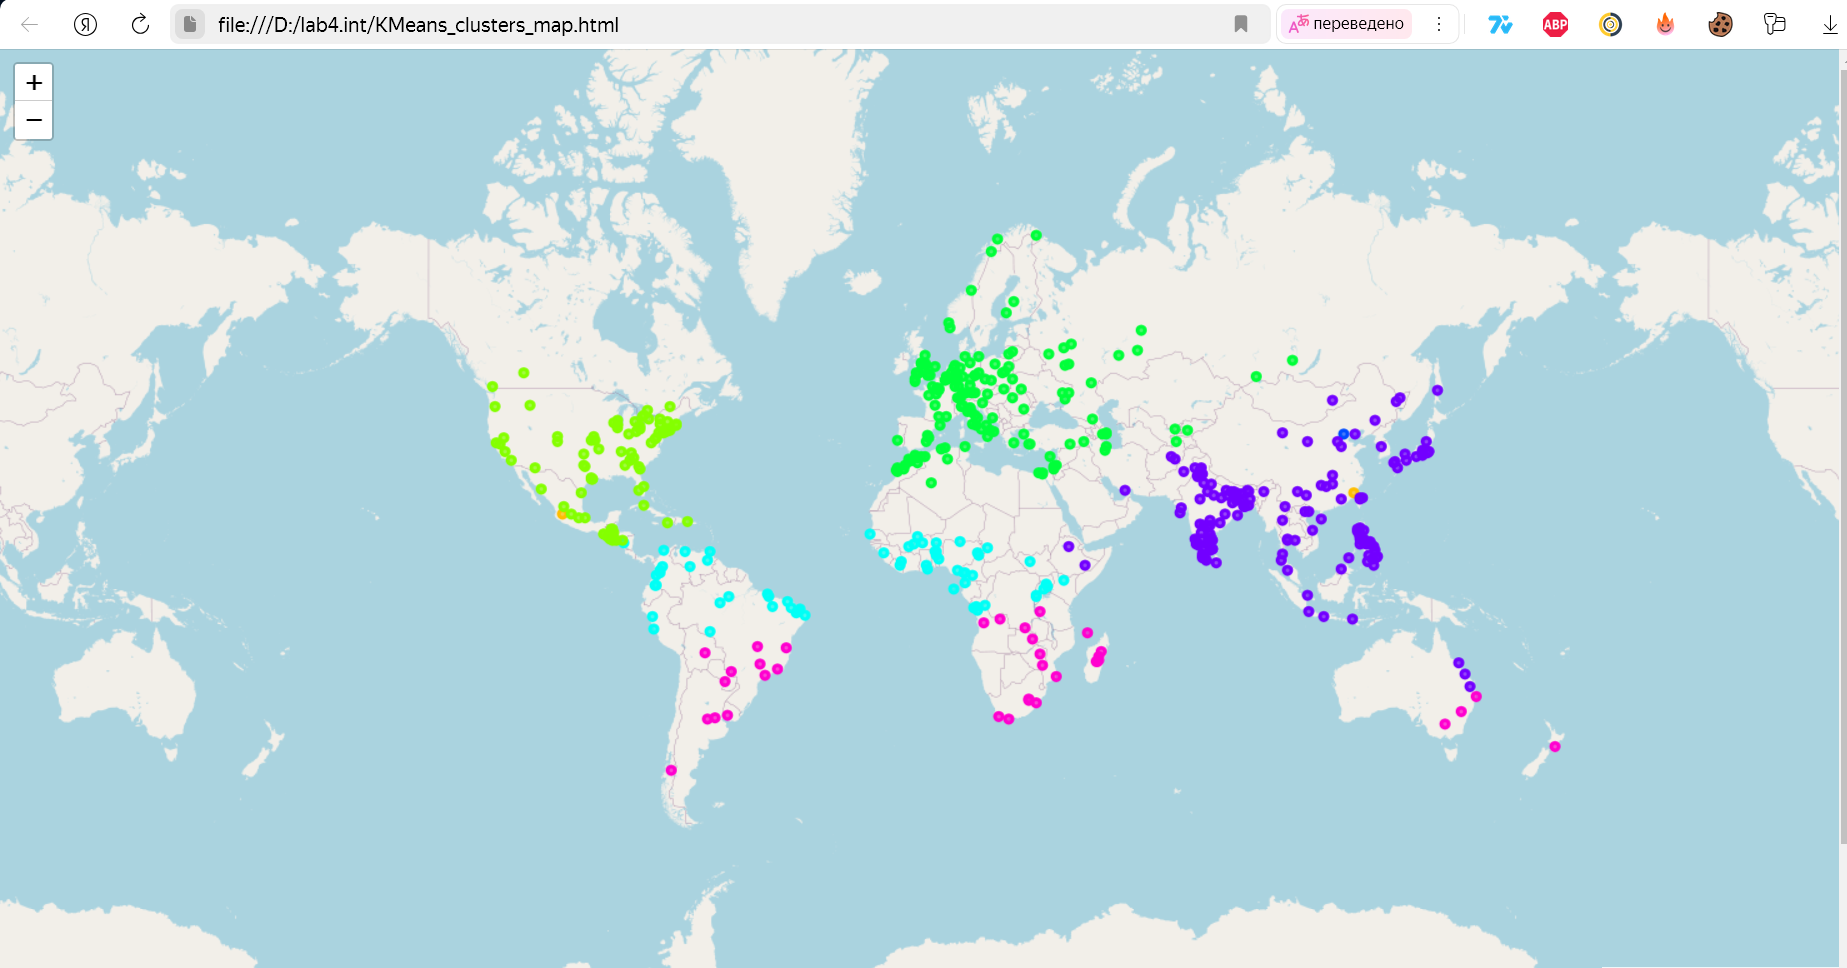

**Карта для DBSCAN**
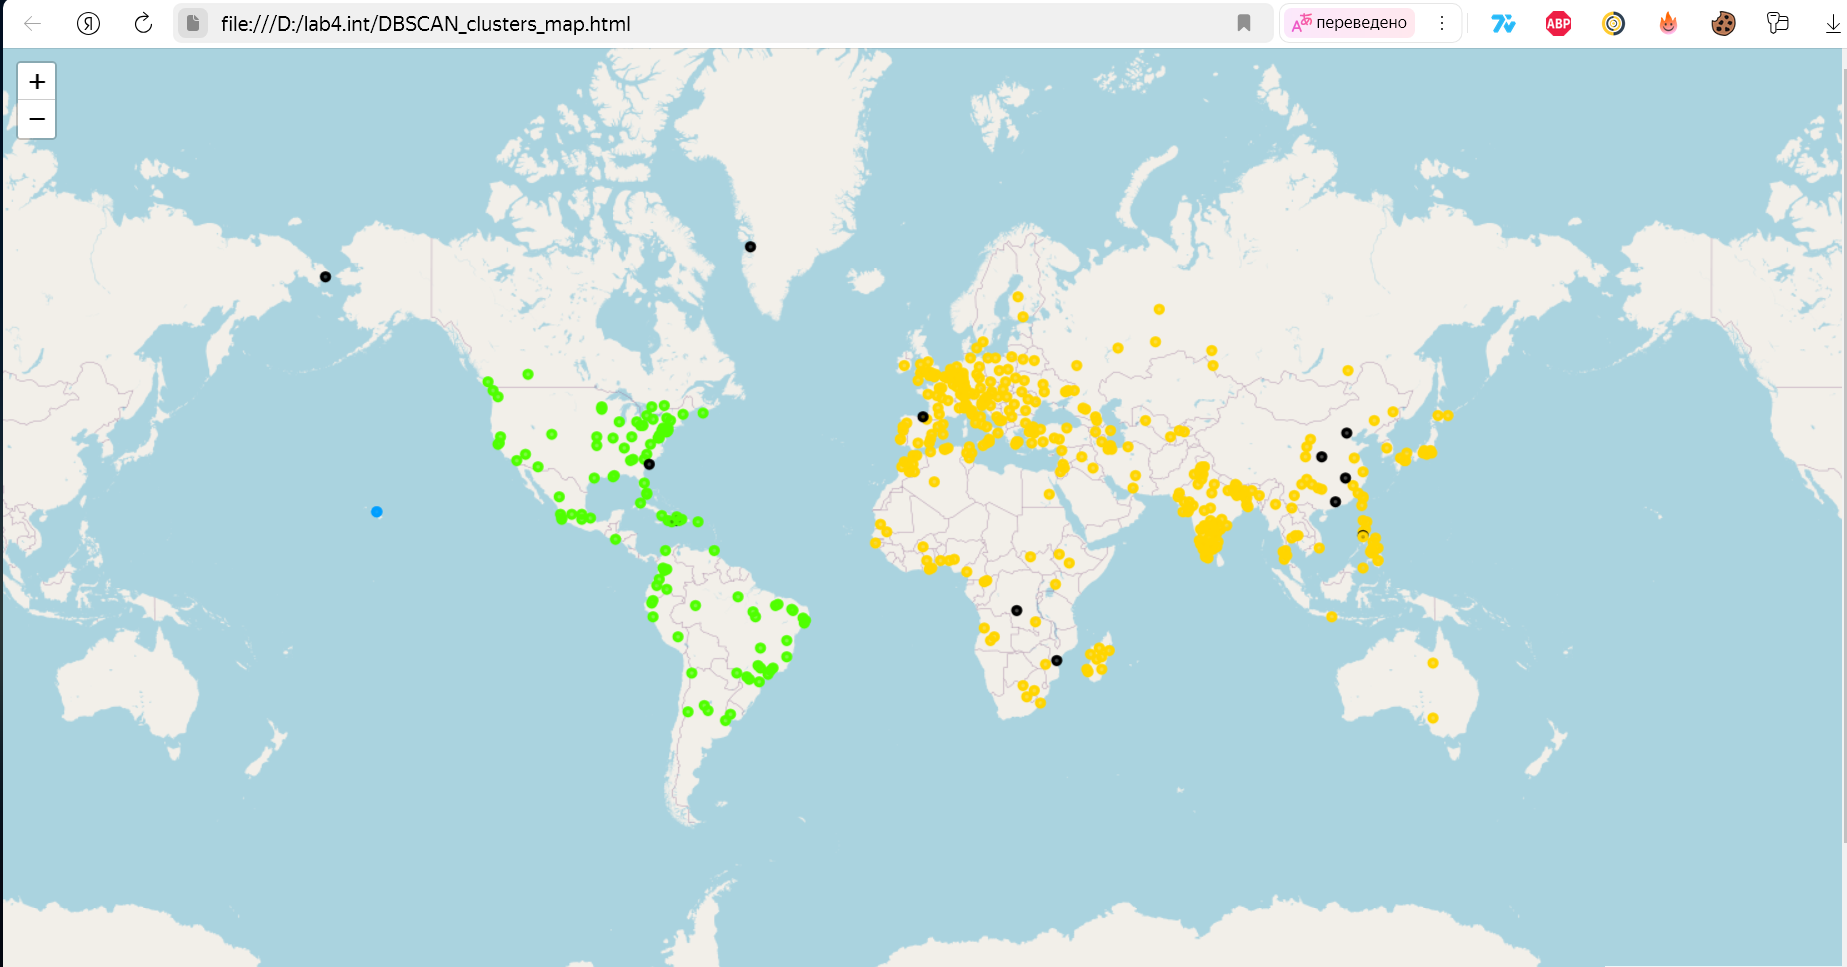

**Карта для Agglomerative clustering**
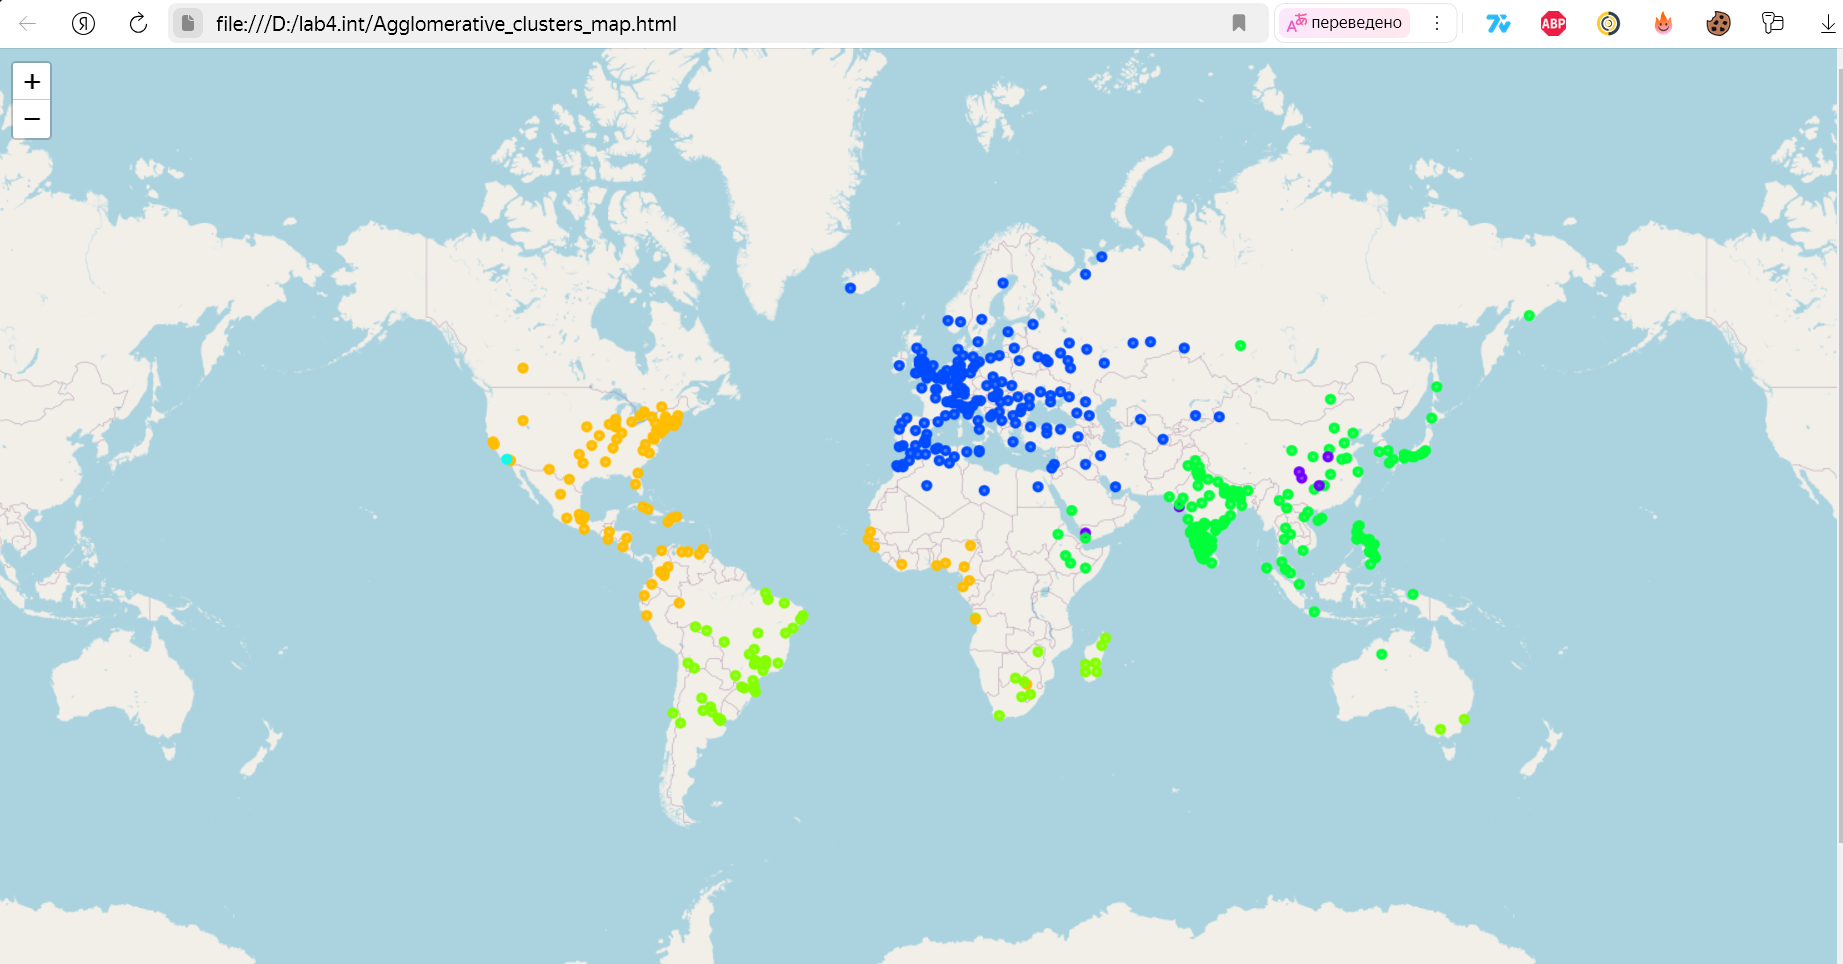

### Объяснение результатов качества кластеризации:

**1. KMeans:**
- **Silhouette Score: 0.512**  
  Этот показатель находится в пределах от -1 до 1. Значение 0.512 говорит о том, что кластеризация достаточно хорошо отделяет кластеры друг от друга. Чем ближе к 1, тем лучше, но это значение указывает на наличие умеренной межклассовой отделимости.
  
- **Calinski-Harabasz Score: 11225.339**  
  Этот индекс оценивает разницу между внутриклассовыми и межклассовыми расстояниями. Более высокое значение указывает на хорошую разделимость кластеров. В данном случае, значение в 11225.339 указывает на то, что кластеры достаточно компактны и хорошо разделены.
  
- **Davies-Bouldin Score: 0.770**  
  Этот индекс измеряет среднюю схожесть кластеров, где низкие значения говорят о лучшей кластеризации. Значение 0.770 указывает на достаточно хорошую разделимость кластеров, хотя возможны некоторые перекрытия.

**2. DBSCAN:**
- **Silhouette Score: 0.240**  
  Этот показатель также указывает на умеренную отделимость кластеров. Значение близкое к 0 (например, 0.240) говорит о том, что алгоритм может испытывать трудности с разделением кластеров, особенно если данные шумные (что характерно для DBSCAN).
  
- **Calinski-Harabasz Score: 1496.882**  
  Это значение значительно ниже, чем у KMeans, что говорит о менее выраженной разделимости кластеров. Это может быть связано с тем, что DBSCAN определяет меньшее количество кластеров и имеет дело с точками шума, которые не принадлежат ни одному кластеру.
  
- **Davies-Bouldin Score: 1.015**  
  Значение, близкое к 1, указывает на то, что кластеры могут быть слишком похожи или пересекаются. Это также подтверждается сравнительно низким значением Calinski-Harabasz.

**3. Agglomerative Clustering:**
- **Silhouette Score: 0.509**  
  Это значение аналогично KMeans, что указывает на умеренно хорошую отделимость кластеров, хотя и не идеально четкую.
  
- **Calinski-Harabasz Score: 10248.592**  
  Значение этого индекса близко к результату KMeans, что также подтверждает достаточно хорошую разделимость кластеров.
  
- **Davies-Bouldin Score: 0.602**  
  Это значение указывает на хорошую разделимость кластеров, несмотря на некоторое перекрытие, что делает агломеративную кластеризацию одной из более успешных в данном эксперименте.

---

**Вывод:**
- **KMeans** продемонстрировал наилучшие результаты по метрике **Calinski-Harabasz**, но с **низким Silhouette Score** и средним **Davies-Bouldin Score**. Это говорит о том, что кластеры хорошо разделены, но качество отделимости может быть улучшено.
- **DBSCAN** показал значительно худшие результаты, что связано с его склонностью находить шум и меньшую плотность кластеров.
- **Agglomerative Clustering** показал стабильные результаты, близкие к KMeans, что делает его хорошим выбором для данных с более сложной структурой кластеров.